In [1]:
from opty import Problem, create_objective_function, parse_free
import sympy as sp
import numpy as np
import time as ts
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, "..")
from importlib import reload
import optyEngine as oe
reload (oe);

In [2]:
### BY JASON MOORE ###
# just different way how create equations of motion,
# here one more speed is introduced, but this approach has a singularity when q0=0

import sympy.physics.mechanics as me
import sympy as sp

t = sp.symbols('t')
q0A, q1A, q2A, q3A, q0B, q1B, q2B, q3B = me.dynamicsymbols('q0A, q1A, q2A, q3A, q0B, q1B, q2B, q3B')  # quaternion
w1A, w2A, w3A, w1B, w2B, w3B = me.dynamicsymbols('w1A, w2A, w3A, w1B, w2B, w3B')  # angular velocities
u0A, u0B = me.dynamicsymbols('u0A u0B')
l = 5
m = 10
g = 9.81
Ixx = 10
Iyy = 1
Izz = 5
F = me.dynamicsymbols('F1:7')


N = me.ReferenceFrame('frame_ground')
N0 = me.Point('point_ground')
N0.set_vel(N,0)

A = me.ReferenceFrame('A')
B = me.ReferenceFrame('B')
mA = me.Point('mA')
mB = me.Point('mB')
ABj = me.Point('ABj')


A.orient(N, 'Quaternion', [q0A, q1A, q2A, q3A])

N_w_A = A.ang_vel_in(N)
 
kinematical1 = sp.Matrix([
    u0A - q0A.diff(t),
    w1A - N_w_A.dot(A.x),
    w2A - N_w_A.dot(A.y),
    w3A - N_w_A.dot(A.z),
])

B.orient(A, 'Quaternion', [q0B, q1B, q2B, q3B])

A_w_B = B.ang_vel_in(A)

kinematical2 = (sp.Matrix([
    u0B - q0B.diff(t),
    w1B - A_w_B.dot(B.x),
    w2B - A_w_B.dot(B.y),
    w3B - A_w_B.dot(B.z),
]))

A.set_ang_vel(N, w1A*A.x + w2A*A.y + w3A*A.z)
B.set_ang_vel(A, w1B*B.x + w2B*B.y + w3B*B.z)

mA.set_pos(N0, -l/2 * A.z)
mA.v2pt_theory(N0,N,A)
FG1 = [(mA, -m * g * N.z)]

ABj.set_pos(N0, -l * A.z)
ABj.v2pt_theory(N0,N,A)


mB.set_pos(ABj, -l/2 * B.z)
mB.v2pt_theory(ABj,N,B)


I1 = me.inertia(A, Ixx, Iyy, Izz)
I2 = me.inertia(B, Ixx, Iyy, Izz)

BODY = []
BODY.append(me.RigidBody('Abody', mA, A, m, (I1, mA)))
BODY.append(me.RigidBody('Bbody', mB, B, m, (I2, mB)))

kinematical = sp.Matrix([[kinematical1],[kinematical2]])

FG2 = [(mB, -m * g * N.z)]
Torque1 = [(A, 500*(F[0]*A.x+F[1]*A.y+F[2]*A.z))]
Torque2 = [(B, 500*(F[3]*B.x+F[4]*B.y+F[5]*B.z))]


holonomic = sp.Matrix([[q0A**2 + q1A**2 + q2A**2 + q3A**2 - 1],
                       [q0B**2 + q1B**2 + q2B**2 + q3B**2 - 1]])
kane = me.KanesMethod(
    N,
    [q1A, q2A, q3A, q1B, q2B, q3B],
    [w1A, w2A, w3A, w1B, w2B, w3B],
    kd_eqs=kinematical,
    q_dependent=[q0A,q0B],
    u_dependent=[u0A,u0B],
    configuration_constraints=holonomic,
    velocity_constraints=holonomic.diff(t),
)
(fr, frstar) = kane.kanes_equations(BODY, (FG1+FG2+Torque1+Torque2))

In [3]:
eoms = sp.Matrix(kinematical).col_join(fr+frstar).col_join(holonomic)

In [4]:
duration = 2 # seconds
num_nodes = 101
interval_value = duration/(num_nodes - 1)
time = np.linspace(0.0, duration, num=num_nodes)

state_symbols = (q0A, q1A, q2A, q3A, q0B, q1B, q2B, q3B, w1A, w2A, w3A, w1B, w2B, w3B, u0A, u0B)
num_states = len(state_symbols)
num_q = 8
specified_symbols = tuple(F)
num_inputs = len(specified_symbols)
t = me.dynamicsymbols._t

In [5]:
import optyEngine as oe
reload (oe);
eul,deul = oe.create_trajectory(num_nodes,duration,interval_value)
traj,w= oe.eul2quat_traj(num_nodes,eul,interval_value)
quat_traj_guess = np.concatenate((traj,w)).flatten()

In [6]:
objective_traj,objective_traj_jac = oe.objective_function(8,interval_value)
obj_min_diff,obj_min_diff_jac = oe.objective_min_diff(num_nodes,interval_value)
# objective_traj_RG,objective_traj_RG_jac = oe.objective_rotglob_quat(8,interval_value)
w_traj = 6
w_force = 1e-4
w_diff_vel = 0.01
w_diff_act = 1e-4
node1 = 0
node2 = 50
node3 = num_nodes-1

def obj(free):
    # min_traj = w_traj * np.sum(objective_traj(np.split(free[:4*2*num_nodes],8),traj))
    min_traj = w_traj * (objective_traj(np.array(np.split(free[:8*num_nodes],8))[:,node1],traj[:,node1]) + objective_traj(np.array(np.split(free[:8*num_nodes],8))[:,node2],traj[:,node2]) + objective_traj(np.array(np.split(free[:8*num_nodes],8))[:,node3],traj[:,node3]))
    min_act_dif = w_diff_act * np.sum((obj_min_diff(np.transpose(np.split(free[num_states*num_nodes:(num_states+num_inputs)*num_nodes],num_inputs)))))
    min_vel_dif = w_diff_vel * np.sum((obj_min_diff(np.transpose(np.split(free[num_q*num_nodes:(num_states)*num_nodes],8)))))

    # min_vel = w_vel * interval_value * np.sum(free[4*2*num_nodes:8*2*num_nodes]**2)
    min_torque = w_force * interval_value * np.sum(free[num_states*num_nodes:(num_states + num_inputs)*num_nodes]**2)
    return (min_traj + min_torque + min_vel_dif+min_act_dif).item()

def obj_grad(free):
    grad = np.zeros_like(free)
    # grad[:4*2*num_nodes] = w_traj * np.concatenate(objective_traj_jac(np.split(free[:4*2*num_nodes],8),traj))
    grad[num_states*num_nodes:(num_states+num_inputs)*num_nodes] = w_diff_act * np.concatenate(np.transpose((obj_min_diff_jac(np.transpose(np.split(free[num_states*num_nodes:(num_states+num_inputs)*num_nodes],num_inputs)))[0,:,:])))

    first_grad_vals = np.array((objective_traj_jac(np.array(np.split(free[:8*num_nodes],8))[:,node1],traj[:,node1])))
    second_grad_vals = np.array((objective_traj_jac(np.array(np.split(free[:8*num_nodes],8))[:,node2],traj[:,node2])))
    third_grad_vals = np.array((objective_traj_jac(np.array(np.split(free[:8*num_nodes],8))[:,node3],traj[:,node3])))
    grad_traj = np.zeros((num_nodes,8))
    grad_traj[node1,:] = first_grad_vals
    grad_traj[node2,:] = second_grad_vals
    grad_traj[node3,:] = third_grad_vals
    grad[:8*num_nodes] = w_traj * np.concatenate(grad_traj.T)
    
    grad[num_q*num_nodes:(num_states)*num_nodes] = w_diff_vel * np.concatenate(np.transpose((obj_min_diff_jac(np.transpose(np.split(free[num_q*num_nodes:(num_states)*num_nodes],8)))[0,:,:])))

    # grad[4*2*num_nodes:8*2*num_nodes] = w_vel * 2 * interval_value * free[4*2*num_nodes:8*2*num_nodes]
    grad[num_states*num_nodes:(num_states + num_inputs)*num_nodes] = w_force * 2.0 * interval_value * free[num_states*num_nodes:(num_states + num_inputs)*num_nodes]
    return grad

In [7]:
# w_traj = 100
# w_vel = 0
# w_force = 0.1

# def obj(free):
#     min_traj = w_traj * interval_value * np.sum((quat_traj - free[:4*2*num_nodes])**2)
#     min_vel = w_vel * interval_value * np.sum(free[3*2*num_nodes:6*2*num_nodes]**2)
#     min_torque = w_force * interval_value * np.sum(free[num_states*num_nodes:(num_states + num_inputs)*num_nodes]**2)
#     return min_traj + min_torque + min_vel

# def obj_grad(free):
#     grad = np.zeros_like(free)
#     grad[:4*2*num_nodes] = w_traj * 2.0 * interval_value * (free[:4*2*num_nodes] - quat_traj)
#     grad[4*2*num_nodes:7*2*num_nodes] = w_vel * 2 * interval_value * free[3*2*num_nodes:6*2*num_nodes]
#     grad[num_states*num_nodes:(num_states + num_inputs)*num_nodes] = w_force * 2.0 * interval_value * free[num_states*num_nodes:(num_states + num_inputs)*num_nodes]
#     return grad

In [8]:
instance_constraints = (
    # q0A.func(0.0) - 1,
    # q1A.func(0.0) - 0,
    # q2A.func(0.0) - 0,
    # q3A.func(0.0) - 0,
    # q0B.func(0.0) - 1,
    # q1B.func(0.0) - 0,
    # q2B.func(0.0) - 0,
    # q3B.func(0.0) - 0,
    w1A.func(0.0) - 0,
    w2A.func(0.0) - 0,
    w3A.func(0.0) - 0,
    w1B.func(0.0) - 0,
    w2B.func(0.0) - 0,
    w3B.func(0.0) - 0,
    u0A.func(0.0) - 0,
    u0B.func(0.0) - 0,
)

max_force = 50000.0
bounds = {
    F[0]: (-max_force, max_force),
    F[1]: (-max_force, max_force),
    F[2]: (-max_force, max_force),
    F[3]: (-max_force, max_force),
    F[4]: (-max_force, max_force),
    F[5]: (-max_force, max_force),
}

In [9]:
start = ts.time()

prob = Problem(obj, obj_grad, eoms, state_symbols,
               num_nodes, interval_value,
               known_parameter_map={},
               instance_constraints=instance_constraints,
               bounds=bounds,
               integration_method='midpoint')

# prob.add_option('nlp_scaling_method', 'gradient-based')

time_to_create = ts.time() - start
print(time_to_create)


12.905247211456299


In [10]:
initial_guess = np.random.randn(prob.num_free)*0
# initial_guess = np.ones(prob.num_free)*0.1
initial_guess[:8*2*num_nodes] = quat_traj_guess
prob.add_option('max_iter',3000)

In [11]:
start = ts.time()

solution, info = prob.solve(initial_guess)

time_to_create = ts.time() - start
print(time_to_create)
print(info['status_msg'])
print(info['obj_val'])
print('OBJ ACT = ', np.sum(solution[num_states*num_nodes:(num_states + num_inputs)*num_nodes]**2))

10.556795835494995
b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
0.0006663852792245245
OBJ ACT =  260.39697529732445


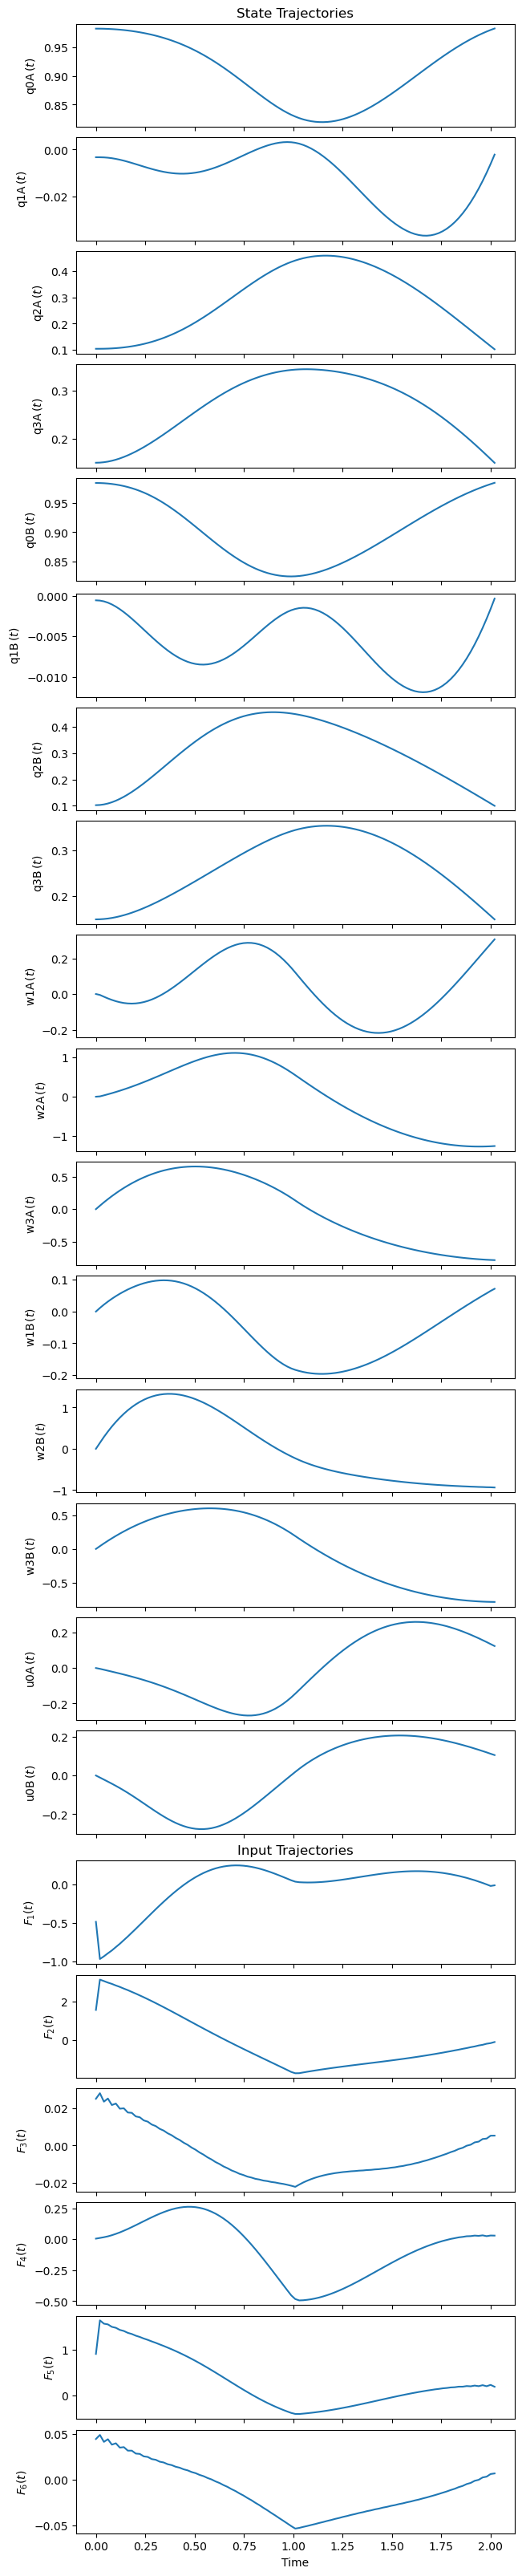

In [12]:
fig, axes = plt.subplots(22, 1, sharex=True,
                         figsize=(6.4, 0.8*40),
                         layout='compressed')
prob.plot_trajectories(solution, axes=axes)

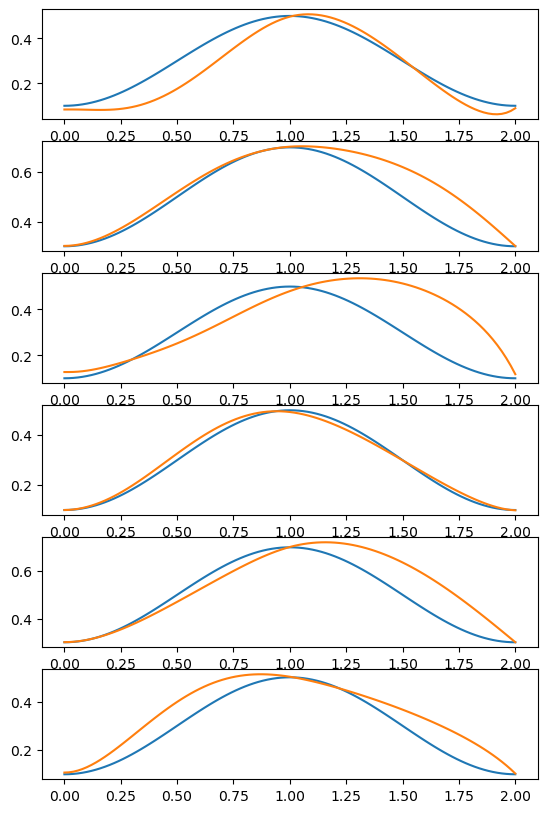

In [13]:
import opty_lib as ol
reload(ol)

fig, axs = plt.subplots(6)
as_euler_sol = ol.sol_quat2eul(solution, 8, num_nodes)
as_euler_guess = ol.sol_quat2eul(quat_traj_guess, 8, num_nodes)
for j in range(6):
    axs[j].plot(time,as_euler_guess[:,j])
    axs[j].plot(time,as_euler_sol[:,j])
    fig.set_figheight(10)

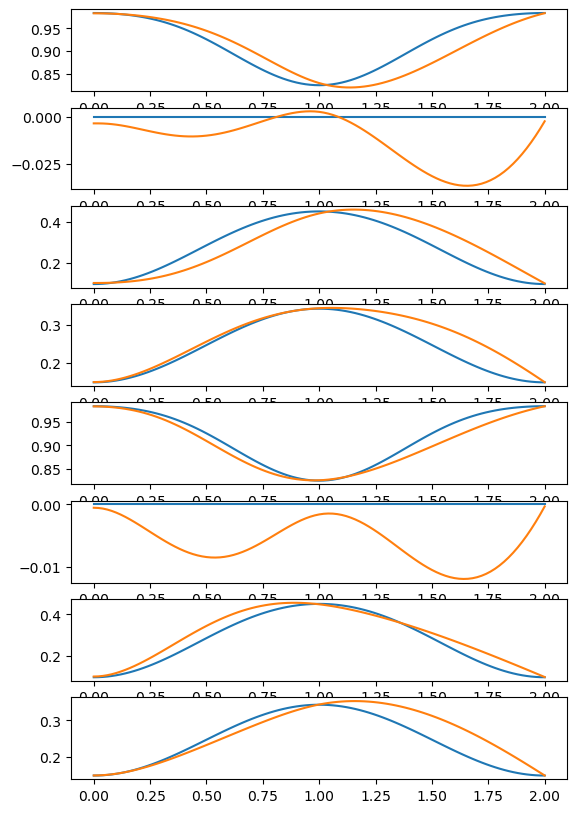

In [14]:
fig, axs = plt.subplots(8)
for j in range(8):
    axs[j].plot(time,quat_traj_guess[j*num_nodes:(j+1)*num_nodes])
    axs[j].plot(time,solution[j*num_nodes:(j+1)*num_nodes])
    fig.set_figheight(10)

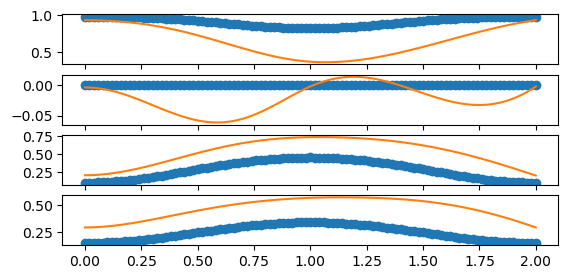

In [15]:
reload (oe);
oe.plot_results(solution,traj[0:len(traj)//2],time,num_nodes)